# OpenFOAM TemporalProbe Analysis

This program shows the evolution of multiple temporal probes for an OpenFOAM case.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 30/05/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [498]:
# Load modules
import numpy as np
import glob, copy
import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

In [499]:
case_dir = '/mnt/internal-hdd/2021_cavitation_water/AJ_channel/hrm_aj2'
variables = ['alphaFrac','p','rho','U']
t_startAveraging = 0.002
MIN_COV=0.25

In [500]:
# Calculate running average in each column of A (excepting 1st column which is time.)
def running_mean(A):
    B = np.zeros_like(A)
    B[:,0] = A[:,0]
    np.cumsum(A[:,1:],axis=0,out=B[:,1:])
    count = np.arange(B.shape[0])+1
    for col in range(1,B.shape[1]):
        B[:,col] /= count
    return B


In [501]:
def makeCoordLabel(i,n,prec=2):
    label = '('
    if prec==1:
        label += ', '.join([ '%.1f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    elif prec==2:
        label += ', '.join([ '%.2f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    elif prec==3:
        label += ', '.join([ '%.3f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    else:
        label += ', '.join([ '%f' % (xyz*1e3) for xyz in (C[i][:,n-1]) ])
    label += ') mm'
    return label

In [502]:
def load_variable(v):
    
    # Get all the data
    files = glob.glob(case_dir+'/temporalProbes/*/'+v)
    
    # Get the time steps
    t0s = [ float(f[len(case_dir)+1:].split('/')[1]) for f in files ]
    
    if len(t0s) == 0:
        raise RuntimeError("No data available for variable `%s'" % v)
    
    # Put them in order
    idx = np.argsort(t0s)

    # Read in the data, in order of the starting time of each subset of data.
    data = []
    for i in tqdm.tqdm(idx): #range(len(idx)):
        if v=='U':
            # Read vector, convert to magnitude
            if i==0: print("Converting velocity vector to magnitude only")
            with open(files[i],'r') as File:
                d = []
                while True:
                    l=File.readline()
                    if len(l)>0:
                        if l[0] != '#':
                            r = []
                            vecSplit = l.strip().split('(')
                            r.append(float(vecSplit[0]))
                            for j in range(1,len(vecSplit)):
                                values = [float(v) for v in vecSplit[j].replace(')','').split()]
                                r.append( np.sqrt(np.sum(np.array(values)**2)) ) # MAGNITUDE OF VECTOR
                            d.append(np.array(r))
                    else: break
                        
            data.append(np.vstack(d))
        else:
            # Read scalar
            data.append( np.genfromtxt(files[i]) )
       
    # Arrange the data into a single large matrix, truncating any repeated timesteps at the end of a run
    A = None
    tmax_last = 0.
    for d in data:
        
        t = d[:,0] # time [s]
        #print(d.shape,t.min(),t.max())
        
        if A is None: # copy
            A = d[...] 
        
        elif t.min() >= tmax_last: # no overlap
            A = np.vstack((A, d))
            
        else: # has overlap - discard end of previous run
            deltat = np.abs(A[:,0] - t.min())
            te = np.where( deltat == np.nanmin(deltat) )[0][0]
            A = np.vstack((A[:te-1], d))
            #print("\tTruncate %i rows" % (A.shape[0]-te))
            
        tmax_last = t.max()
        
    del data
        
        
    # Finally, get the co-ordinate positions of each column of data by reading the header.
    with open(files[i],'r') as File:
        header=[]
        for n in range(3):
            header.append(File.readline())
    coords=np.array([ [ float(s) for s in h.strip().split()[2:] ] for h in header ])
    
    
    return A, coords

In [503]:
D=[]
C=[]
for v in variables:
    print("Loading %s" % v)
    A, coords = load_variable(v)
    D.append(A)
    C.append(coords)

 29%|██▊       | 2/7 [00:00<00:00, 18.58it/s]

Loading alphaFrac


 29%|██▊       | 2/7 [00:00<00:00, 18.56it/s]

Loading p


 29%|██▊       | 2/7 [00:00<00:00, 18.74it/s]

Loading rho


 14%|█▍        | 1/7 [00:00<00:01,  5.23it/s]

Loading U
Converting velocity vector to magnitude only


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


In [504]:
# Calculate total pressure if U rho and p are available
if 'U' in variables and 'rho' in variables and 'p' in variables:
    print("Calculating total and dynamic pressure")
    
    iU=variables.index('U')
    iR=variables.index('rho')
    iP=variables.index('p')
    q = 0.5*D[iR]*D[iU]**2
    p = D[iP]
    
    variables.append('Total pressure')
    D.append(q+p)
    D[-1][:,0] = D[iP][:,0]
    C.append(C[-1])
    
print(len(D),len(C),len(variables))

Calculating total and dynamic pressure
5 5 5


<IPython.core.display.Javascript object>


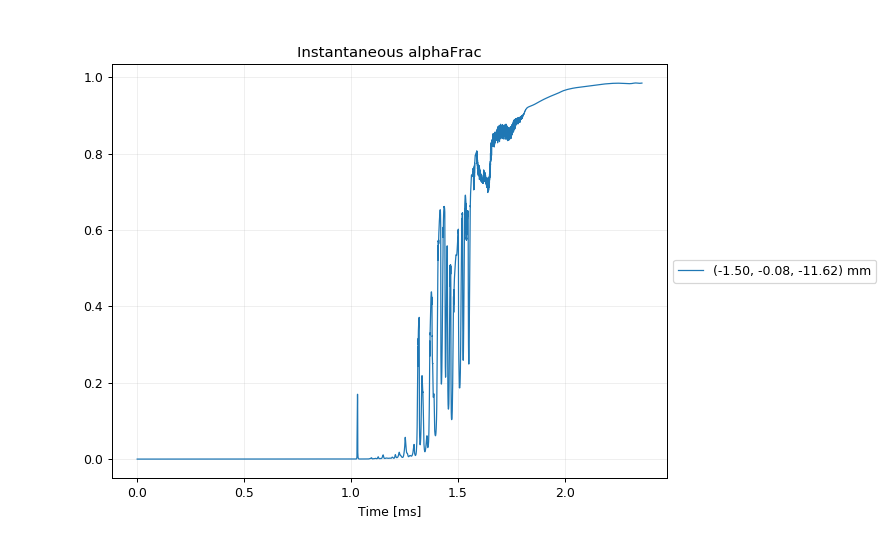

<IPython.core.display.Javascript object>


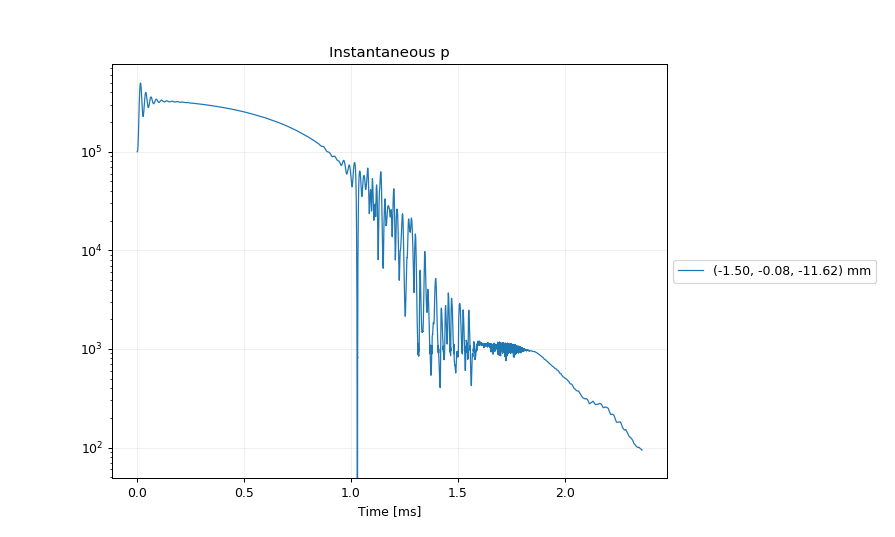

<IPython.core.display.Javascript object>


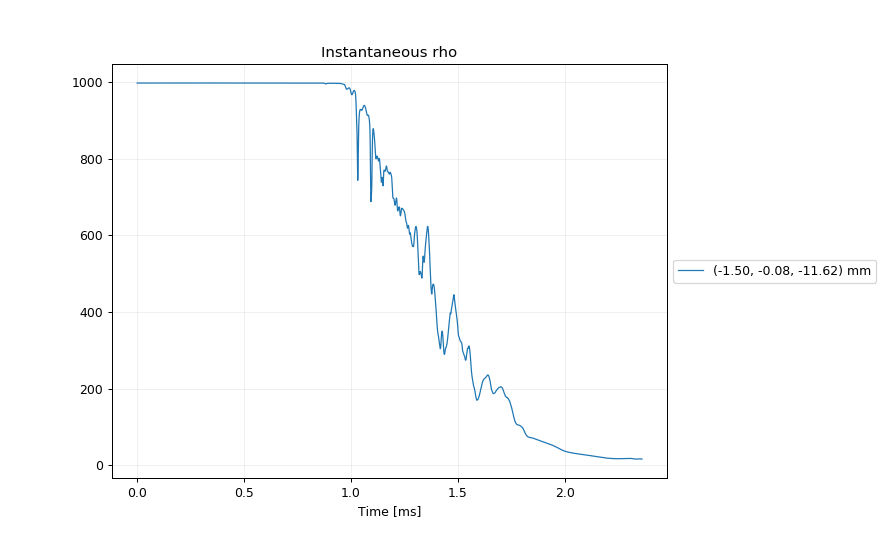

<IPython.core.display.Javascript object>


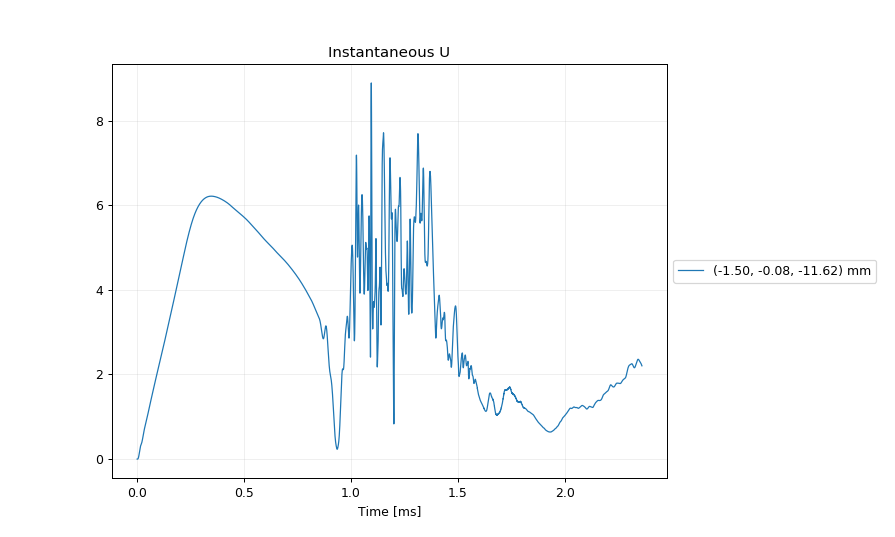

<IPython.core.display.Javascript object>


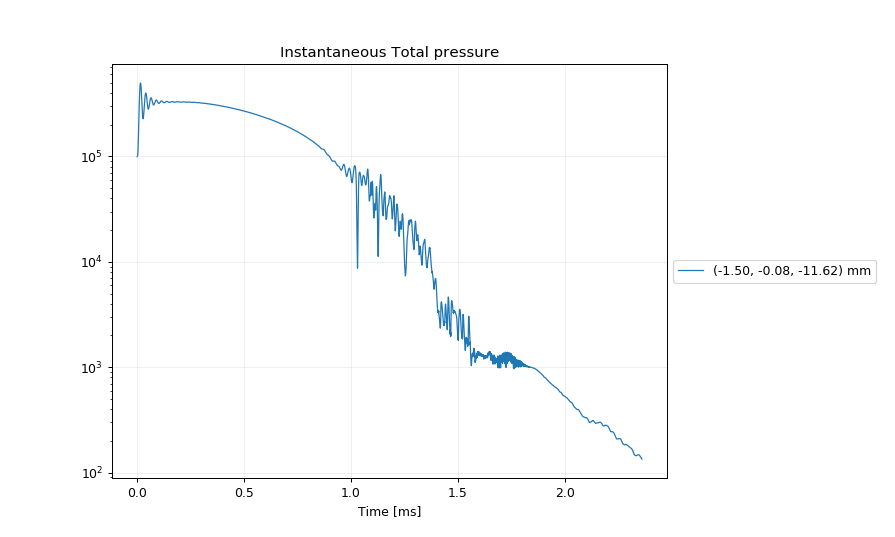

In [518]:
for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111)
    plt.grid(alpha=.2)
    for n in [13]: #range(1,A.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if cov>=MIN_COV:
            ax.plot(t*1e3, A[:,n], lw=1, label=makeCoordLabel(i,n))
            if v=='p' or 'pressure' in v: ax.set_yscale('log')
        else:
            print("Skipped plotting n=%i @ %s - no significant variation over time"%(n,makeCoordLabel(i,n)))
    plt.xlabel('Time [ms]')
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title("Instantaneous "+v);

In [ ]:
# RUNNING AVERAGE
for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    
    t0 = np.where(t >= t_startAveraging )[0][0] # start averaging here.
    B = running_mean(A[t0:,...])
    
    
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111)
    plt.grid(alpha=.2)
    for n in range(1,B.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if cov>=MIN_COV:
            ax.plot(B[:,0], B[:,n], lw=1, label=makeCoordLabel(i,n))
        else:
            print("Skipped plotting n=%i @ %s - no significant variation over time"%(n,makeCoordLabel(i,n)))
            
    plt.xlabel('Time [s]')
    plt.xlim(t_startAveraging,)
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title("Running average "+v);

In [ ]:
# WATERFALL PLOT
from scipy.signal import spectrogram

for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    dt = np.nanmean(np.diff(t))
    fig=plt.figure(figsize=(10,12)) # plot size can be edited as required
    m=1
    row=4 # rows of graphs to draw - edit as required
    col=2 # columns of graphs to draw - edit as required
    if i==0: print("SAMPLING RATE = %f MHz" % (1e-6/dt))
    for n in range(1,A.shape[1]):
        # Determine coefficient of variance. Must pass threshold to be worth plotting!
        cov=np.std(A[:,n])/(1e-12+np.nanmean(A[:,n]))
        if (m<row*col):
            if (cov>=MIN_COV):
                ax=fig.add_subplot(row,col,m)
                yf,yt,yS=spectrogram( A[:,n], fs=1.0/dt, mode='magnitude')
                SS=20*np.log10(yS+np.nanmax(yS)/1000)
                yf[yf<2.0/(len(t)*dt)]=2.0/(len(t)*dt)
                tt,ff = np.meshgrid(yt*1e3,yf)
                CH=ax.contourf(tt,ff,SS,cmap=plt.cm.jet)
                plt.colorbar(CH,label='arbitrary dB')
                plt.xlabel('Time [ms]')
                plt.ylabel('Freq [Hz]')
                plt.title('Spectrum @ x,y,z = %s' % makeCoordLabel(i,n))
                plt.ylim(ff.min(),ff.max())
                plt.yscale('log')  
                m+=1
                
                # Find maxima frequency and time
                pi=np.where(SS==np.nanmax(SS))
                pf=ff[pi]
                pt=tt[pi]
                print("\nn=%i @ %s: Peak spectral power %g dB at f=%g kHz, t=%g ms" % (n,makeCoordLabel(i,n,prec=3),\
                                                                            np.nanmax(SS),pf*1e-3,pt))
                ax.scatter([pt],[pf],marker='x',c='w',zorder=10)
            else:
                print("\nSkipped plotting n=%i @ %s - no significant variation over time" % (n,\
                                                                                makeCoordLabel(i,n)))
        else:
            print("Out of plot space")
            break
    plt.suptitle("Waterfall "+v)
    plt.subplots_adjust(top=.925,bottom=.05,left=.1,right=.95,hspace=.6,wspace=.2);
    plt.savefig("waterfall_%s.pdf" % v)